In [ ]:
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as pt
from tabulate import tabulate

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline

In [ ]:
d=pd.read_csv('deliveries.csv')
m=pd.read_csv('matches.csv')
p=pd.read_csv('points_table.csv')

In [ ]:
d.tail()

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,extras,wides,noballs,byes,legbyes,penalty,wicket_type,player_dismissed,other_wicket_type,other_player_dismissed
26114,45,2023/24,2023-11-12,"M Chinnaswamy Stadium, Bengaluru",2,47.1,Netherlands,India,PA van Meekeren,AT Nidamanuru,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26115,45,2023/24,2023-11-12,"M Chinnaswamy Stadium, Bengaluru",2,47.2,Netherlands,India,PA van Meekeren,AT Nidamanuru,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26116,45,2023/24,2023-11-12,"M Chinnaswamy Stadium, Bengaluru",2,47.3,Netherlands,India,AT Nidamanuru,PA van Meekeren,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26117,45,2023/24,2023-11-12,"M Chinnaswamy Stadium, Bengaluru",2,47.4,Netherlands,India,AT Nidamanuru,PA van Meekeren,...,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26118,45,2023/24,2023-11-12,"M Chinnaswamy Stadium, Bengaluru",2,47.5,Netherlands,India,AT Nidamanuru,PA van Meekeren,...,0,NaN,NaN,NaN,NaN,NaN,caught,AT Nidamanuru,NaN,NaN


In [ ]:
print(d.columns)
print(m.columns)

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'other_wicket_type',
       'other_player_dismissed'],
      dtype='object')
Index(['season', 'team1', 'team2', 'date', 'match_number', 'venue', 'city',
       'toss_winner', 'toss_decision', 'player_of_match', 'umpire1', 'umpire2',
       'reserve_umpire', 'match_referee', 'winner', 'winner_runs',
       'winner_wickets', 'match_type'],
      dtype='object')


In [ ]:
m.rename(columns={'match_number':'match_id','start_date':'date','winner_runs':'win_by_runs','winner_wickets':'win_by_wickets'},inplace=True)
print(d.isna().sum())
print(m.isna().sum())

match_id                      0
season                        0
start_date                    0
venue                         0
innings                       0
ball                          0
batting_team                  0
bowling_team                  0
striker                       0
non_striker                   0
bowler                        0
runs_off_bat                  0
extras                        0
wides                     25454
noballs                   26063
byes                      26081
legbyes                   25926
penalty                   26118
wicket_type               25390
player_dismissed          25390
other_wicket_type         26118
other_player_dismissed    26118
dtype: int64
season              0
team1               0
team2               0
date                0
match_id            0
venue               0
city                0
toss_winner         0
toss_decision       0
player_of_match     0
umpire1             0
umpire2             0
reserve_umpire     

In [ ]:
d['wicket']=d['player_dismissed'].apply(lambda x: 1 if isinstance(x,str) else 0)
d[['wides','noballs','byes','legbyes','penalty']]=d[['wides','noballs','byes','legbyes','penalty']].fillna(0)

d.wicket_type.fillna('no wicket', inplace=True)
d.player_dismissed.fillna('no wicket', inplace=True)

d[["other_wicket_type", "other_player_dismissed"]] = d[["other_wicket_type", "other_player_dismissed"]].fillna("no dismissal")

d.isna().sum()

match_id                  0
season                    0
start_date                0
venue                     0
innings                   0
ball                      0
batting_team              0
bowling_team              0
striker                   0
non_striker               0
bowler                    0
runs_off_bat              0
extras                    0
wides                     0
noballs                   0
byes                      0
legbyes                   0
penalty                   0
wicket_type               0
player_dismissed          0
other_wicket_type         0
other_player_dismissed    0
wicket                    0
dtype: int64

In [ ]:
m.win_by_runs.fillna(0, inplace=True)
m.win_by_wickets.fillna(0, inplace=True)
m.reserve_umpire.fillna('unknown', inplace=True)
m.isna().sum()

season             0
team1              0
team2              0
date               0
match_id           0
venue              0
city               0
toss_winner        0
toss_decision      0
player_of_match    0
umpire1            0
umpire2            0
reserve_umpire     0
match_referee      0
winner             0
win_by_runs        0
win_by_wickets     0
match_type         0
dtype: int64

In [ ]:
d['ball']=d['ball'].astype(str)
d[['over','ball_num']]=d['ball'].str.split('.',expand=True).astype(int)
d['balls']=1
d['ball']=d['ball'].astype(float)
d['over']=d['over']+1
d['ball_left']=306-(d['over']*6 + d['ball_num'])

In [ ]:
d['total_runs']=d['runs_off_bat']+d['extras']

In [ ]:
innings=d.groupby(['match_id','innings'])['total_runs'].sum().reset_index()
innings.rename(columns={'total_runs':'innings_total'}, inplace=True)

deli=d.merge(innings, on=['match_id','innings'])
deli['cumulative_runs']=deli.groupby(['match_id','innings'])['total_runs'].cumsum()
deli['run_rate']=deli.groupby(['match_id','innings']).apply(lambda x: (x["cumulative_runs"]*6)/(300-x["ball_left"])).reset_index(level=[0,1], drop=True)
deli.head()

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,other_player_dismissed,wicket,over,ball_num,balls,ball_left,total_runs,innings_total,cumulative_runs,run_rate
0,1,2023/24,2023-10-05,"Narendra Modi Stadium, Ahmedabad",1,0.1,England,New Zealand,JM Bairstow,DJ Malan,...,no dismissal,0,1,1,1,299,0,282,0,0.0
1,1,2023/24,2023-10-05,"Narendra Modi Stadium, Ahmedabad",1,0.2,England,New Zealand,JM Bairstow,DJ Malan,...,no dismissal,0,1,2,1,298,6,282,6,18.0
2,1,2023/24,2023-10-05,"Narendra Modi Stadium, Ahmedabad",1,0.3,England,New Zealand,JM Bairstow,DJ Malan,...,no dismissal,0,1,3,1,297,1,282,7,14.0
3,1,2023/24,2023-10-05,"Narendra Modi Stadium, Ahmedabad",1,0.4,England,New Zealand,DJ Malan,JM Bairstow,...,no dismissal,0,1,4,1,296,1,282,8,12.0
4,1,2023/24,2023-10-05,"Narendra Modi Stadium, Ahmedabad",1,0.5,England,New Zealand,JM Bairstow,DJ Malan,...,no dismissal,0,1,5,1,295,4,282,12,14.4


In [ ]:
innings_1=deli[deli['innings']==1]
innings_1=innings_1.groupby('match_id')['cumulative_runs'].max().reset_index()
innings_1.rename(columns={"cumulative_runs": "target"}, inplace=True)

innings_2=deli[deli['innings']==2]
innings_2=innings_2.merge(innings_1, on='match_id', how='left')
innings_2['target']=innings_2['target']+1
innings_2['runs_needed']=innings_2['target']-innings_2['cumulative_runs']
innings_2['required_run_rate']=(innings_2['runs_needed']*6) / innings_2["ball_left"]

In [ ]:
innings1=deli[deli['innings']==1]
innings1['wickets_remaining']=innings1.groupby('match_id')['wicket'].apply(lambda x: 10-x.cumsum()).reset_index(level=0, drop=True)

<ipython-input-12-b16532a8696b>:2: FutureWarning: Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)
  innings1['wickets_remaining']=innings1.groupby('match_id')['wicket'].apply(lambda x: 10-x.cumsum()).reset_index(level=0, drop=True)
<ipython-input-12-b16532a8696b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  innings1['wickets_remaining']=innings1.groupby('match_id')['wicket'].apply(lambda x: 10-x.cumsum()).reset_inde

In [ ]:
innings=pd.concat([innings1,innings_2])
innings.tail()

,match_id,season,start_date,venue,innings,ball,batting_team,bowling_team,striker,non_striker,...,balls,ball_left,total_runs,innings_total,cumulative_runs,run_rate,wickets_remaining,target,runs_needed,required_run_rate
11719,45,2023/24,2023-11-12,"M Chinnaswamy Stadium, Bengaluru",2,47.1,Netherlands,India,PA van Meekeren,AT Nidamanuru,...,1,17,0,250,243,5.151943,NaN,411.0,168.0,59.294118
11720,45,2023/24,2023-11-12,"M Chinnaswamy Stadium, Bengaluru",2,47.2,Netherlands,India,PA van Meekeren,AT Nidamanuru,...,1,16,1,250,244,5.154930,NaN,411.0,167.0,62.625000
11721,45,2023/24,2023-11-12,"M Chinnaswamy Stadium, Bengaluru",2,47.3,Netherlands,India,AT Nidamanuru,PA van Meekeren,...,1,15,0,250,244,5.136842,NaN,411.0,167.0,66.800000
11722,45,2023/24,2023-11-12,"M Chinnaswamy Stadium, Bengaluru",2,47.4,Netherlands,India,AT Nidamanuru,PA van Meekeren,...,1,14,6,250,250,5.244755,NaN,411.0,161.0,69.000000
11723,45,2023/24,2023-11-12,"M Chinnaswamy Stadium, Bengaluru",2,47.5,Netherlands,India,AT Nidamanuru,PA van Meekeren,...,1,13,0,250,250,5.226481,NaN,411.0,161.0,74.307692


In [ ]:
innings['venue'] = innings['venue'].replace(['Arun Jaitley Stadium, Delhi', 'MA Chidambaram Stadium, Chepauk, Chennai', 'Himachal Pradesh Cricket Association Stadium, Dharamsala', 'Bharat Ratna Shri Atal Bihari Vajpayee Ekana Cricket Stadium, Lucknow', 'Rajiv Gandhi International Stadium, Uppal, Hyderabad', 'Maharashtra Cricket Association Stadium, Pune', 'Wankhede Stadium, Mumbai', 'Eden Gardens, Kolkata', 'Narendra Modi Stadium, Ahmedabad', 'M Chinnaswamy Stadium, Bengaluru'], ['Delhi', 'Chennai', 'Dharamsala', 'Lucknow', 'Hyderabad', 'Pune', 'Mumbai', 'Kolkata', 'Ahmedabad', 'Bengaluru'])

In [ ]:
innings.fillna(0, inplace=(True))
innings.isna().sum()

match_id                  0
season                    0
start_date                0
venue                     0
innings                   0
ball                      0
batting_team              0
bowling_team              0
striker                   0
non_striker               0
bowler                    0
runs_off_bat              0
extras                    0
wides                     0
noballs                   0
byes                      0
legbyes                   0
penalty                   0
wicket_type               0
player_dismissed          0
other_wicket_type         0
other_player_dismissed    0
wicket                    0
over                      0
ball_num                  0
balls                     0
ball_left                 0
total_runs                0
innings_total             0
cumulative_runs           0
run_rate                  0
wickets_remaining         0
target                    0
runs_needed               0
required_run_rate         0
dtype: int64

In [ ]:
innings=innings[~((innings.required_run_rate>500) | (innings.run_rate>100))]

In [ ]:
innings=innings.merge(m[['match_id','winner','win_by_runs','win_by_wickets']], on='match_id')

In [ ]:
innings['result']=innings.apply(lambda x: 1 if x['batting_team']==x['winner'] else 0, axis=1)

In [ ]:
cols=['venue', 'batting_team', 'bowling_team', 'ball', 'innings_total', 'wickets_remaining', 'run_rate', 'required_run_rate','ball_left', 'runs_needed','win_by_runs', 'win_by_wickets', 'target', 'result']
innings[cols].tail()

,venue,batting_team,bowling_team,ball,innings_total,wickets_remaining,run_rate,required_run_rate,ball_left,runs_needed,win_by_runs,win_by_wickets,target,result
26113,Bengaluru,Netherlands,India,47.1,250,0.0,5.151943,59.294118,17,168.0,160.0,0.0,411.0,0
26114,Bengaluru,Netherlands,India,47.2,250,0.0,5.154930,62.625000,16,167.0,160.0,0.0,411.0,0
26115,Bengaluru,Netherlands,India,47.3,250,0.0,5.136842,66.800000,15,167.0,160.0,0.0,411.0,0
26116,Bengaluru,Netherlands,India,47.4,250,0.0,5.244755,69.000000,14,161.0,160.0,0.0,411.0,0
26117,Bengaluru,Netherlands,India,47.5,250,0.0,5.226481,74.307692,13,161.0,160.0,0.0,411.0,0


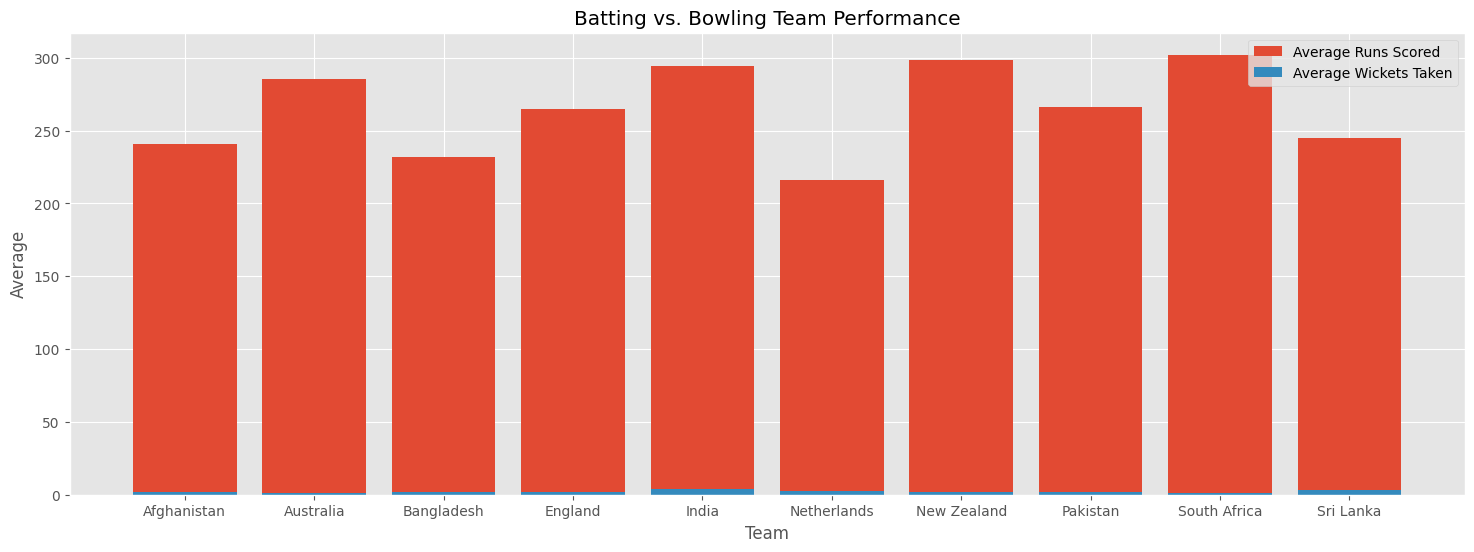

In [ ]:
pt.style.use('ggplot')
avg_runs_batting = innings.groupby('batting_team')['innings_total'].mean()

# Calculate the average wickets taken per bowling team
avg_wickets_bowling = innings.groupby('bowling_team')['wickets_remaining'].mean()

pt.figure(figsize=(18,6))
pt.bar(avg_runs_batting.index, avg_runs_batting.values, label='Average Runs Scored')
pt.bar(avg_wickets_bowling.index, avg_wickets_bowling.values, label='Average Wickets Taken')
pt.xlabel('Team')
pt.ylabel('Average')
pt.title('Batting vs. Bowling Team Performance')
pt.legend()
pt.show()

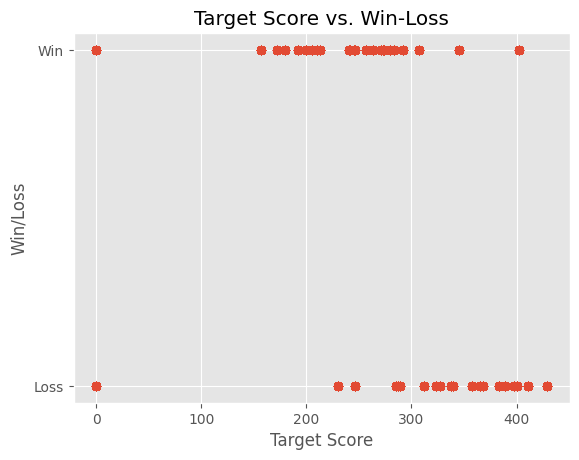

In [ ]:
innings['win_loss'] = innings['result'].apply(lambda x: 'Win' if x==1 else 'Loss')

pt.scatter(innings['target'], innings['win_loss'])
pt.xlabel('Target Score')
pt.ylabel('Win/Loss')
pt.title('Target Score vs. Win-Loss')
pt.show()

In [ ]:
innings['venue'].value_counts()

Chennai       2854
Dharamsala    2793
Pune          2791
Ahmedabad     2735
Kolkata       2697
Mumbai        2688
Delhi         2678
Lucknow       2669
Bengaluru     2458
Hyderabad     1755
Name: venue, dtype: int64

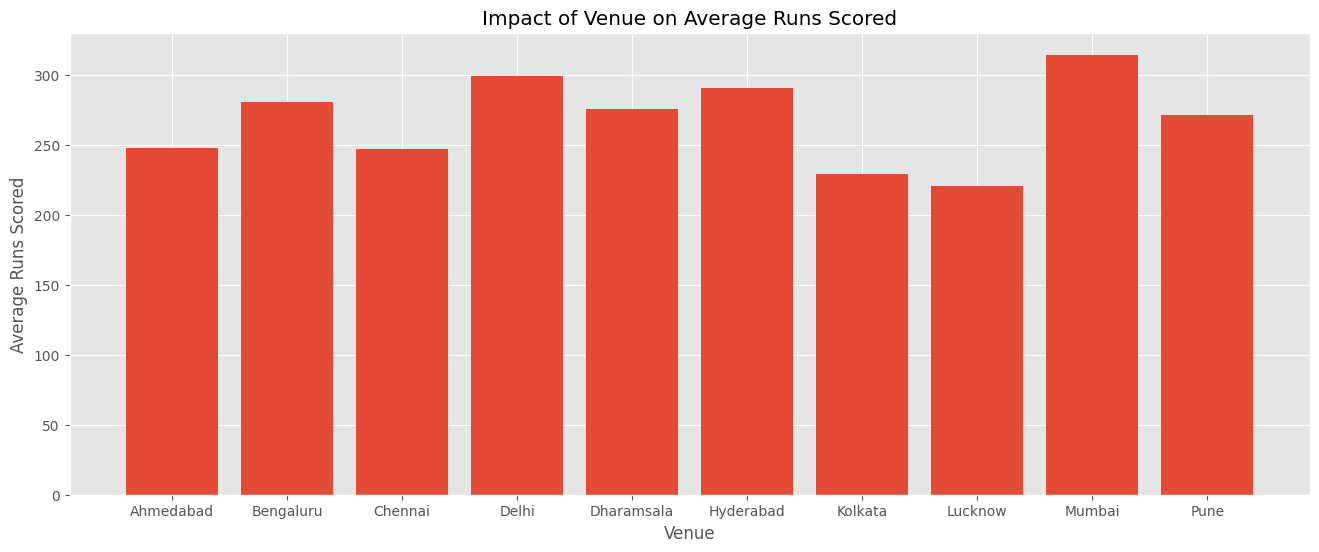

In [ ]:
ven = innings.groupby('venue')['innings_total'].mean()

pt.figure(figsize=(16,6))
pt.bar(ven.index, ven.values)
pt.xlabel('Venue')
pt.ylabel('Average Runs Scored')
pt.title('Impact of Venue on Average Runs Scored')
pt.show()

In [ ]:
match_id = 5  # Replace with the match ID
match_data = innings[innings['match_id'] == match_id]

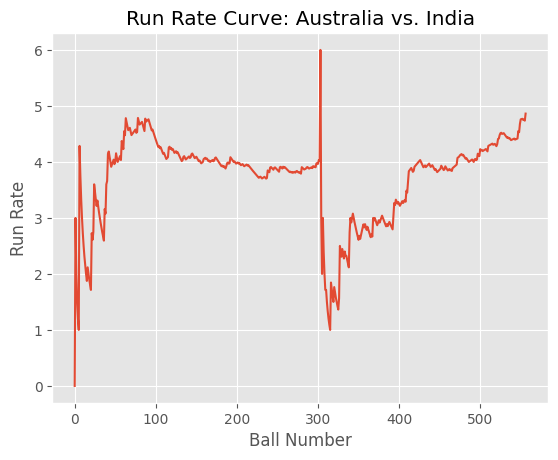

In [ ]:
innings_total = match_data['innings_total'].tolist()
ball_left = match_data['ball_left'].tolist()

run_rate = match_data['run_rate']

pt.figure()
pt.plot(range(len(run_rate)), run_rate)
pt.xlabel('Ball Number')
pt.ylabel('Run Rate')
pt.title('Run Rate Curve: '+str(match_data['batting_team'].iat[0])+' vs. '+str(match_data['bowling_team'].iat[0]))
pt.show()

In [ ]:
innings.columns

Index(['match_id', 'season', 'start_date', 'venue', 'innings', 'ball',
       'batting_team', 'bowling_team', 'striker', 'non_striker', 'bowler',
       'runs_off_bat', 'extras', 'wides', 'noballs', 'byes', 'legbyes',
       'penalty', 'wicket_type', 'player_dismissed', 'other_wicket_type',
       'other_player_dismissed', 'wicket', 'over', 'ball_num', 'balls',
       'ball_left', 'total_runs', 'innings_total', 'cumulative_runs',
       'run_rate', 'wickets_remaining', 'target', 'runs_needed',
       'required_run_rate', 'winner', 'win_by_runs', 'win_by_wickets',
       'result', 'win_loss'],
      dtype='object')

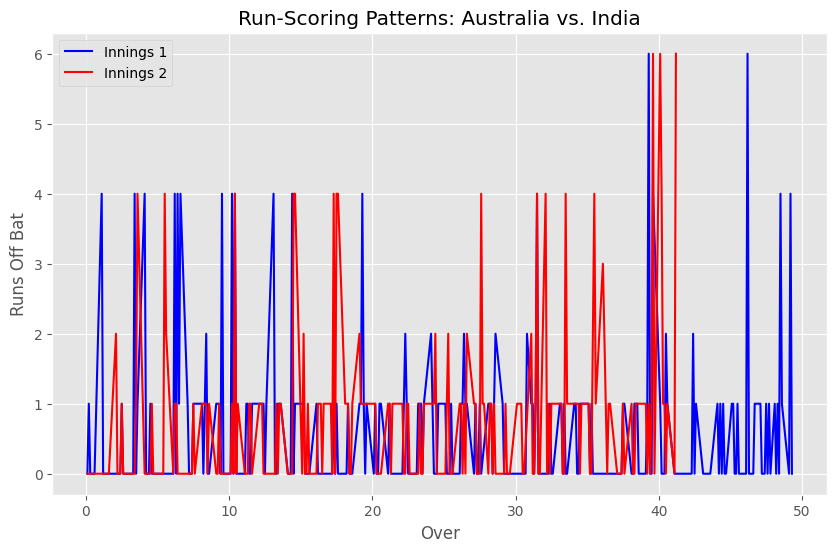

In [ ]:
# Separate the data for innings 1 and 2
innings1_data = match_data[match_data['innings'] == 1]
innings2_data = match_data[match_data['innings'] == 2]

# Plot the run-scoring patterns
pt.figure(figsize=(10, 6))

pt.plot(innings1_data['ball'], innings1_data['runs_off_bat'], label='Innings 1',color='b')
pt.plot(innings2_data['ball'], innings2_data['runs_off_bat'], label='Innings 2',color='r')

pt.xlabel('Over')
pt.ylabel('Runs Off Bat')
pt.title('Run-Scoring Patterns: '+str(match_data['batting_team'].iat[0])+' vs. '+str(match_data['bowling_team'].iat[0]))
pt.legend()
pt.show()

In [ ]:
player_performance = match_data.groupby('striker')['runs_off_bat','balls','wicket'].sum().reset_index()
player_performance['strike_rate'] = (player_performance['runs_off_bat'] / player_performance['balls']) * 100

top_performers = player_performance.sort_values(by=['runs_off_bat', 'wicket'], ascending=[False, True]).head(5)

print(tabulate(top_performers,headers=['Striker','Runs','Balls','Dismissed','Strike Rate'],tablefmt='psql',showindex="never"))

+-----------+--------+---------+-------------+---------------+
| Striker   |   Runs |   Balls |   Dismissed |   Strike Rate |
|-----------+--------+---------+-------------+---------------|
| KL Rahul  |     97 |     116 |           0 |       83.6207 |
| V Kohli   |     85 |     119 |           1 |       71.4286 |
| SPD Smith |     46 |      71 |           1 |       64.7887 |
| DA Warner |     41 |      52 |           1 |       78.8462 |
| MA Starc  |     28 |      37 |           1 |       75.6757 |
+-----------+--------+---------+-------------+---------------+


<ipython-input-28-d799f5a5450b>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  player_performance = match_data.groupby('striker')['runs_off_bat','balls','wicket'].sum().reset_index()


In [ ]:
venue_groups = innings.groupby('venue')['run_rate'].mean()

print('Impact of Venue:')
print(venue_groups)

Impact of Venue:
venue
Ahmedabad     5.551473
Bengaluru     6.176781
Chennai       4.861601
Delhi         6.107487
Dharamsala    5.676152
Hyderabad     5.270652
Kolkata       4.728773
Lucknow       4.808495
Mumbai        5.609358
Pune          5.185097
Name: run_rate, dtype: float64


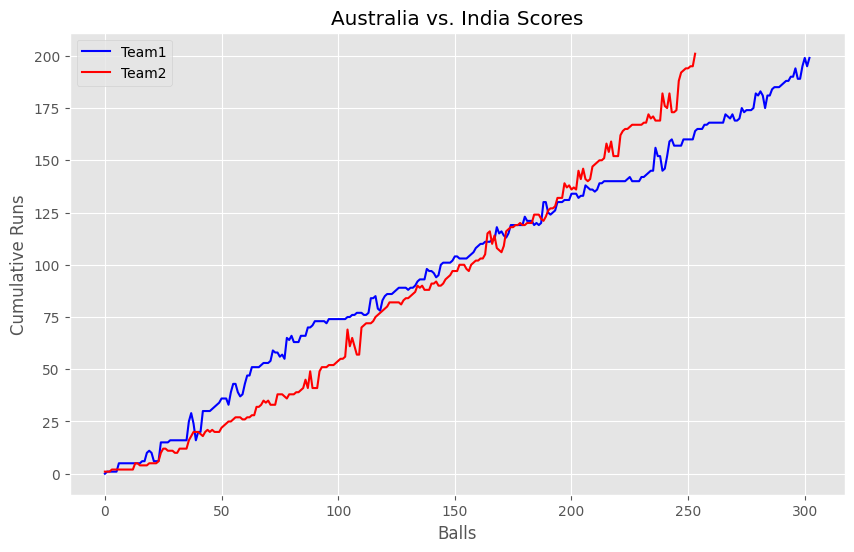

In [ ]:
team1_data = match_data[match_data['innings'] == 1].sort_values(by=['over'], ascending=True)
team2_data = match_data[match_data['innings'] == 2].sort_values(by=['over'], ascending=True)

team1_runs = team1_data['cumulative_runs'].tolist()
team2_runs = team2_data['cumulative_runs'].tolist()

pt.figure(figsize=(10,6))
pt.plot(team1_runs, label='Team1', color='blue')
pt.plot(team2_runs, label='Team2', color='red')

pt.xlabel('Balls')
pt.ylabel('Cumulative Runs')
pt.title(str(match_data['batting_team'].iat[0])+' vs. '+str(match_data['bowling_team'].iat[0])+' Scores')
pt.legend()
pt.show()

In [ ]:
bowler_performance = match_data.groupby('bowler')['wicket'].sum().reset_index()
bowler_performance.sort_values(by='wicket', inplace=True, ascending=False)

# Identify the bowler with the highest wickets
highest_wicket_taker = bowler_performance.head()

# Show the bowler with the highest wickets
print('Highest Wickets by Bowlers:')
print(tabulate(highest_wicket_taker,headers=['Player','Wickets'],tablefmt='psql',showindex="never"))

Highest Wickets by Bowlers:
+---------------+-----------+
| Player        |   Wickets |
|---------------+-----------|
| JR Hazlewood  |         3 |
| RA Jadeja     |         3 |
| JJ Bumrah     |         2 |
| Kuldeep Yadav |         2 |
| HH Pandya     |         1 |
+---------------+-----------+


In [ ]:
total_runs_per_match = innings.groupby(['match_id', 'striker'])['runs_off_bat'].sum()

# Identify centuries for each batsman in each match
centuries = total_runs_per_match[total_runs_per_match >= 100]

# Count the number of centuries scored by each batsman
centuries_per_batsman = centuries.groupby('striker').size().reset_index(name='centuries')

# Identify the batsman with the highest number of centuries
highest_centurion = centuries_per_batsman.sort_values(by='centuries', ascending=False).head(4)

# Print the highest number of centuries scored
print(tabulate(highest_centurion,headers=['Striker','Centuries'],tablefmt='psql',showindex="never"))

+------------+-------------+
| Striker    |   Centuries |
|------------+-------------|
| Q de Kock  |           4 |
| V Kohli    |           3 |
| R Ravindra |           3 |
| TM Head    |           2 |
+------------+-------------+


In [ ]:
m.player_of_match.value_counts().head()

Mohammed Shami    3
TM Head           3
RG Sharma         2
GJ Maxwell        2
V Kohli           2
Name: player_of_match, dtype: int64

In [ ]:
co=['venue', 'batting_team', 'bowling_team', 'innings', 'cumulative_runs', 'ball', 'target', 'result']
train_data=innings[co]

xtrain=train_data.drop('result', axis=1)
ytrain=train_data['result']

#xtrain,xtest,ytrain,ytest=train_test_split(x,y,test_size=0.3, random_state=100)

In [ ]:
one=[col for col in xtrain.columns if xtrain[col].dtypes not in (int,float)]
scale=[col for col in xtrain.columns if xtrain[col].dtypes in (int,float)]

one,scale

(['venue', 'batting_team', 'bowling_team'],
 ['innings', 'cumulative_runs', 'ball', 'target'])

In [ ]:
ct = make_column_transformer((OneHotEncoder(sparse=False, drop='first'),one),remainder='passthrough')
pipe=make_pipeline(ct, LogisticRegression(solver='liblinear'))

pipe.fit(xtrain,ytrain)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('onehotencoder',
                                                  OneHotEncoder(drop='first',
                                                                sparse=False),
                                                  ['venue', 'batting_team',
                                                   'bowling_team'])])),
                ('logisticregression', LogisticRegression(solver='liblinear'))])

In [ ]:
pred=pipe.predict(xtrain)
acc=accuracy_score(ytrain,pred)
acc

0.8874722413661077

In [ ]:
train_data.head()

,venue,batting_team,bowling_team,innings,cumulative_runs,ball,target,result
0,Ahmedabad,England,New Zealand,1,0,0.1,0.0,0
1,Ahmedabad,England,New Zealand,1,6,0.2,0.0,0
2,Ahmedabad,England,New Zealand,1,7,0.3,0.0,0
3,Ahmedabad,England,New Zealand,1,8,0.4,0.0,0
4,Ahmedabad,England,New Zealand,1,12,0.5,0.0,0


In [ ]:
train_data['venue'].value_counts()

Chennai       2854
Dharamsala    2793
Pune          2791
Ahmedabad     2735
Kolkata       2697
Mumbai        2688
Delhi         2678
Lucknow       2669
Bengaluru     2458
Hyderabad     1755
Name: venue, dtype: int64

In [ ]:
co=['venue', 'batting_team', 'bowling_team', 'innings', 'cumulative_runs', 'ball', 'target', 'result']
data = [['Ahmedabad', 'India', 'Australia', 1, 290, 50.0, 0]]
df = pd.DataFrame(data, columns=['venue', 'batting_team', 'bowling_team', 'innings', 'cumulative_runs', 'ball', 'target'])
df

print(pipe.predict(df))
print(pipe.predict_proba(df))

[1]
[[0.4542748 0.5457252]]
